# Battery life cycle prediction - deep learning model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
import pickle
import matplotlib.pyplot as plt
import gc
from pathlib import Path
from IPython.display import display

import src.constants as cst
import src.features.rebuilding_features as rf
import src.models.train_model as tm
#from src.data.data_class import BatteryData
#from src.data.load_data import DataLoader
#from src.data.wrangle_data import DataWrangler

#from rebuilding_features import load_batches_to_dict
from src.visualization.helpers import print_dict_keys
from os.path import join
import src.models.data_pipeline as dp

import tensorflow as tf
import pandas as pd
import seaborn as sns
from matplotlib import style
import itertools
import warnings
import json
import seaborn as sns
import src.constants as cst

import src.models.data_pipeline as dp  # TODO: Have to refactor this code out of this class.
import src.models.split_model as split_model
import src.models.full_cnn_model as full_cnn_model
from src.models.callbacks import CustomCheckpoints

warnings.filterwarnings('ignore')


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
#session = tf.compat.v1.Session(config=config)
#tf.compat.v1.keras.backend.set_session(session)
import os
from pandas import datetime

DATA_DIR = join("../../data/external")


In [4]:
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def calculate_steps_per_epoch(data_dir, dataset_config):
    temp_dataset = dp.create_dataset(data_dir=data_dir,
                                     window_size=dataset_config["window_size"],
                                     shift=dataset_config["shift"],
                                     stride=dataset_config["stride"],
                                     batch_size=dataset_config["batch_size"],
                                     repeat=False)
    steps_per_epoch = 0
    for batch in temp_dataset:
        steps_per_epoch += 1
    return steps_per_epoch

def get_tboard_dir():
    run_timestr = datetime.now().strftime("%Y%m%d-%H%M%S")
    tboard_dir = os.path.join(cst.TENSORBOARD_DIR, "jobs", run_timestr)
    return tboard_dir

# Deep Learning model

We build a deep learning model by


In [6]:
args = tm.get_args()
#model_trainer = tm.ModelTrainer(None, args)
#model_trainer.train_and_evaluate()

In [7]:
scaling_factors = dp.load_scaling_factors()
dataset_dir = cst.TEST_SET
window_size = 20
shift = 5
stride = 1
batch_size = 32
hparams = None
save_from = 80
tboard = get_tboard_dir()

print (tboard)

dataset = dp.create_dataset(dataset_dir,
                            window_size=window_size,
                            shift=shift,  # Can vary during validation
                            stride=stride,
                            batch_size=batch_size,  # Can vary during validation
                            cycle_length=1,  # To match original order (so no files get interleaved)
                            num_parallel_calls=1,  # Has to be equal or below cycle_length
                            shuffle=None,  # To match original order
                            repeat=None)

# Config datasets for consistent usage
ds_config = dict(window_size=window_size,
                 shift=shift,
                 stride=stride,
                 batch_size=batch_size)
ds_train_path = cst.TRAIN_SET
ds_val_path = cst.TEST_SET

# create model
if args.model == 'split_model':
    print("Using split model!")
    model = split_model.create_keras_model(window_size=ds_config["window_size"],
                                           loss=args.loss,
                                           hparams_config=hparams)
if args.model == 'full_cnn_model':
    print("Using full cnn model!")
    model = full_cnn_model.create_keras_model(window_size=ds_config["window_size"],
                                              loss=args.loss,
                                              hparams_config=hparams)

# Calculate steps_per_epoch_train, steps_per_epoch_test
# This is needed, since for counting repeat has to be false
steps_per_epoch_train = calculate_steps_per_epoch(ds_train_path, ds_config)

steps_per_epoch_validate = calculate_steps_per_epoch(ds_val_path, ds_config)

# load datasets
dataset_train = dp.create_dataset(data_dir=ds_train_path,
                                  window_size=ds_config["window_size"],
                                  shift=ds_config["shift"],
                                  stride=ds_config["stride"],
                                  batch_size=ds_config["batch_size"])

dataset_validate = dp.create_dataset(data_dir=ds_val_path,
                                     window_size=ds_config["window_size"],
                                     shift=ds_config["shift"],
                                     stride=ds_config["stride"],
                                     batch_size=ds_config["batch_size"])

# if hparams is passed, we're running a HPO-job
if hparams:
    checkpoint_callback = CustomCheckpoints(save_last_only=True,
                                            log_dir=tboard,
                                            dataset_path=ds_val_path,
                                            dataset_config=ds_config,
                                            save_eval_plot=False)
else:
    checkpoint_callback = CustomCheckpoints(save_best_only=True,
                                            start_epoch=save_from,
                                            log_dir=tboard,
                                            dataset_path=ds_val_path,
                                            dataset_config=ds_config,
                                            save_eval_plot=False)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=tboard,
                                   histogram_freq=0,
                                   write_graph=False,
                                   ),
    checkpoint_callback,
]

model.summary()

# train model
history = model.fit(
    dataset_train,
    epochs=500,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=dataset_validate,
    validation_steps=steps_per_epoch_validate,
    verbose=2,
    callbacks=callbacks)

mae_current = min(history.history["val_mae_current_cycle"])
mae_remaining = min(history.history["val_mae_remaining_cycles"])

#return mae_current, mae_remaining

Graph\jobs\20220502-113036
Using split model!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Qdlin (InputLayer)              [(None, 20, 1000, 1) 0                                            
__________________________________________________________________________________________________
Tdlin (InputLayer)              [(None, 20, 1000, 1) 0                                            
__________________________________________________________________________________________________
detail_concat (Concatenate)     (None, 20, 1000, 2)  0           Qdlin[0][0]                      
                                                                 Tdlin[0][0]                      
__________________________________________________________________________________________________
convolution (TimeDistributed)   (None, 20, 334, 

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_80_loss_0.013155225664377213\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_80_loss_0.013155225664377213\assets


Epoch 82/500
168/168 - 4s - loss: 0.0080 - mae_current_cycle: 134.3973 - mae_remaining_cycles: 111.3307 - val_loss: 0.0173 - val_mae_current_cycle: 165.2642 - val_mae_remaining_cycles: 250.5347
Epoch 83/500
168/168 - 4s - loss: 0.0109 - mae_current_cycle: 167.1567 - mae_remaining_cycles: 140.7673 - val_loss: 0.0135 - val_mae_current_cycle: 159.4248 - val_mae_remaining_cycles: 160.6854
Epoch 84/500
168/168 - 4s - loss: 0.0089 - mae_current_cycle: 148.4656 - mae_remaining_cycles: 125.6527 - val_loss: 0.0197 - val_mae_current_cycle: 248.2251 - val_mae_remaining_cycles: 168.6970
Epoch 85/500
168/168 - 4s - loss: 0.0121 - mae_current_cycle: 184.6810 - mae_remaining_cycles: 134.4435 - val_loss: 0.0124 - val_mae_current_cycle: 152.4147 - val_mae_remaining_cycles: 153.2168


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_84_loss_0.012398910708725452\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_84_loss_0.012398910708725452\assets


Epoch 86/500
168/168 - 5s - loss: 0.0093 - mae_current_cycle: 153.7459 - mae_remaining_cycles: 127.7271 - val_loss: 0.0141 - val_mae_current_cycle: 142.8499 - val_mae_remaining_cycles: 162.9301
Epoch 87/500
168/168 - 4s - loss: 0.0082 - mae_current_cycle: 135.1174 - mae_remaining_cycles: 123.7610 - val_loss: 0.0097 - val_mae_current_cycle: 134.2759 - val_mae_remaining_cycles: 139.0718


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_86_loss_0.009660108014941216\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_86_loss_0.009660108014941216\assets


Epoch 88/500
168/168 - 4s - loss: 0.0075 - mae_current_cycle: 126.7808 - mae_remaining_cycles: 119.2653 - val_loss: 0.0189 - val_mae_current_cycle: 196.9680 - val_mae_remaining_cycles: 174.6792
Epoch 89/500
168/168 - 4s - loss: 0.0081 - mae_current_cycle: 134.7870 - mae_remaining_cycles: 123.0939 - val_loss: 0.0160 - val_mae_current_cycle: 174.4663 - val_mae_remaining_cycles: 169.5415
Epoch 90/500
168/168 - 4s - loss: 0.0085 - mae_current_cycle: 142.7530 - mae_remaining_cycles: 115.6793 - val_loss: 0.0124 - val_mae_current_cycle: 158.6327 - val_mae_remaining_cycles: 152.0499
Epoch 91/500
168/168 - 4s - loss: 0.0071 - mae_current_cycle: 126.2276 - mae_remaining_cycles: 113.7996 - val_loss: 0.0104 - val_mae_current_cycle: 125.7269 - val_mae_remaining_cycles: 143.3475
Epoch 92/500
168/168 - 4s - loss: 0.0074 - mae_current_cycle: 128.9721 - mae_remaining_cycles: 120.9259 - val_loss: 0.0185 - val_mae_current_cycle: 189.6762 - val_mae_remaining_cycles: 157.6140
Epoch 93/500
168/168 - 4s - lo

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_119_loss_0.009485913440585136\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_119_loss_0.009485913440585136\assets


Epoch 121/500
168/168 - 4s - loss: 0.0071 - mae_current_cycle: 137.6656 - mae_remaining_cycles: 110.2688 - val_loss: 0.0135 - val_mae_current_cycle: 139.7599 - val_mae_remaining_cycles: 181.0941
Epoch 122/500
168/168 - 4s - loss: 0.0078 - mae_current_cycle: 142.4431 - mae_remaining_cycles: 116.9311 - val_loss: 0.0122 - val_mae_current_cycle: 182.7657 - val_mae_remaining_cycles: 158.5437
Epoch 123/500
168/168 - 4s - loss: 0.0118 - mae_current_cycle: 171.7893 - mae_remaining_cycles: 133.0729 - val_loss: 0.0153 - val_mae_current_cycle: 155.0880 - val_mae_remaining_cycles: 167.3859
Epoch 124/500
168/168 - 4s - loss: 0.0084 - mae_current_cycle: 136.9948 - mae_remaining_cycles: 125.4212 - val_loss: 0.0138 - val_mae_current_cycle: 152.9560 - val_mae_remaining_cycles: 159.6241
Epoch 125/500
168/168 - 4s - loss: 0.0069 - mae_current_cycle: 117.7614 - mae_remaining_cycles: 121.3002 - val_loss: 0.0098 - val_mae_current_cycle: 132.9041 - val_mae_remaining_cycles: 137.3259
Epoch 126/500
168/168 - 4

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_142_loss_0.00849460531026125\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_142_loss_0.00849460531026125\assets


Epoch 144/500
168/168 - 5s - loss: 0.0078 - mae_current_cycle: 116.3293 - mae_remaining_cycles: 129.7439 - val_loss: 0.0119 - val_mae_current_cycle: 144.4747 - val_mae_remaining_cycles: 152.2399
Epoch 145/500
168/168 - 4s - loss: 0.0073 - mae_current_cycle: 116.4368 - mae_remaining_cycles: 120.6479 - val_loss: 0.0156 - val_mae_current_cycle: 142.2939 - val_mae_remaining_cycles: 178.2656
Epoch 146/500
168/168 - 4s - loss: 0.0085 - mae_current_cycle: 128.8549 - mae_remaining_cycles: 128.1220 - val_loss: 0.0140 - val_mae_current_cycle: 150.3775 - val_mae_remaining_cycles: 156.1811
Epoch 147/500
168/168 - 4s - loss: 0.0084 - mae_current_cycle: 133.2835 - mae_remaining_cycles: 120.0388 - val_loss: 0.0166 - val_mae_current_cycle: 154.9532 - val_mae_remaining_cycles: 182.4426
Epoch 148/500
168/168 - 5s - loss: 0.0084 - mae_current_cycle: 133.1490 - mae_remaining_cycles: 128.0007 - val_loss: 0.0119 - val_mae_current_cycle: 157.5681 - val_mae_remaining_cycles: 168.3885
Epoch 149/500
168/168 - 4

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_157_loss_0.00837877206504345\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_157_loss_0.00837877206504345\assets


Epoch 159/500
168/168 - 5s - loss: 0.0062 - mae_current_cycle: 109.9567 - mae_remaining_cycles: 114.4179 - val_loss: 0.0107 - val_mae_current_cycle: 132.1732 - val_mae_remaining_cycles: 149.3457
Epoch 160/500
168/168 - 5s - loss: 0.0077 - mae_current_cycle: 124.9800 - mae_remaining_cycles: 123.8925 - val_loss: 0.0111 - val_mae_current_cycle: 136.9613 - val_mae_remaining_cycles: 154.0062
Epoch 161/500
168/168 - 5s - loss: 0.0066 - mae_current_cycle: 121.7254 - mae_remaining_cycles: 108.1713 - val_loss: 0.0131 - val_mae_current_cycle: 190.5355 - val_mae_remaining_cycles: 152.4375
Epoch 162/500
168/168 - 4s - loss: 0.0135 - mae_current_cycle: 180.7069 - mae_remaining_cycles: 141.0963 - val_loss: 0.0174 - val_mae_current_cycle: 190.5716 - val_mae_remaining_cycles: 159.5264
Epoch 163/500
168/168 - 5s - loss: 0.0081 - mae_current_cycle: 122.0653 - mae_remaining_cycles: 130.1784 - val_loss: 0.0191 - val_mae_current_cycle: 177.5388 - val_mae_remaining_cycles: 172.9430
Epoch 164/500
168/168 - 5

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_293_loss_0.00789477676153183\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_293_loss_0.00789477676153183\assets


Epoch 295/500
168/168 - 5s - loss: 0.0064 - mae_current_cycle: 103.9278 - mae_remaining_cycles: 118.7516 - val_loss: 0.0121 - val_mae_current_cycle: 125.7993 - val_mae_remaining_cycles: 153.2715
Epoch 296/500
168/168 - 5s - loss: 0.0059 - mae_current_cycle: 102.9991 - mae_remaining_cycles: 109.3198 - val_loss: 0.0155 - val_mae_current_cycle: 155.3609 - val_mae_remaining_cycles: 166.0460
Epoch 297/500
168/168 - 5s - loss: 0.0055 - mae_current_cycle: 103.4300 - mae_remaining_cycles: 102.0648 - val_loss: 0.0113 - val_mae_current_cycle: 152.2336 - val_mae_remaining_cycles: 151.7790
Epoch 298/500
168/168 - 5s - loss: 0.0075 - mae_current_cycle: 135.1634 - mae_remaining_cycles: 113.6070 - val_loss: 0.0121 - val_mae_current_cycle: 114.9119 - val_mae_remaining_cycles: 211.6570
Epoch 299/500
168/168 - 5s - loss: 0.0066 - mae_current_cycle: 111.9487 - mae_remaining_cycles: 119.5430 - val_loss: 0.0123 - val_mae_current_cycle: 130.7255 - val_mae_remaining_cycles: 155.0501
Epoch 300/500
168/168 - 5

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_345_loss_0.007757311221212149\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_345_loss_0.007757311221212149\assets


Epoch 347/500
168/168 - 5s - loss: 0.0056 - mae_current_cycle: 98.2662 - mae_remaining_cycles: 108.8232 - val_loss: 0.0139 - val_mae_current_cycle: 155.0484 - val_mae_remaining_cycles: 154.0278
Epoch 348/500
168/168 - 4s - loss: 0.0049 - mae_current_cycle: 94.1599 - mae_remaining_cycles: 97.3658 - val_loss: 0.0084 - val_mae_current_cycle: 126.8553 - val_mae_remaining_cycles: 133.5173
Epoch 349/500
168/168 - 4s - loss: 0.0064 - mae_current_cycle: 106.4138 - mae_remaining_cycles: 115.5728 - val_loss: 0.0097 - val_mae_current_cycle: 134.4055 - val_mae_remaining_cycles: 130.2113
Epoch 350/500
168/168 - 4s - loss: 0.0058 - mae_current_cycle: 101.6446 - mae_remaining_cycles: 108.3883 - val_loss: 0.0160 - val_mae_current_cycle: 158.4664 - val_mae_remaining_cycles: 161.7394
Epoch 351/500
168/168 - 5s - loss: 0.0059 - mae_current_cycle: 106.0094 - mae_remaining_cycles: 105.5143 - val_loss: 0.0127 - val_mae_current_cycle: 144.6749 - val_mae_remaining_cycles: 148.5953
Epoch 352/500
168/168 - 4s -

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_357_loss_0.007251381408423185\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_357_loss_0.007251381408423185\assets


Epoch 359/500
168/168 - 4s - loss: 0.0062 - mae_current_cycle: 93.9630 - mae_remaining_cycles: 112.9216 - val_loss: 0.0132 - val_mae_current_cycle: 193.8830 - val_mae_remaining_cycles: 134.6141
Epoch 360/500
168/168 - 5s - loss: 0.0045 - mae_current_cycle: 100.5029 - mae_remaining_cycles: 92.7406 - val_loss: 0.0087 - val_mae_current_cycle: 132.3390 - val_mae_remaining_cycles: 131.4379
Epoch 361/500
168/168 - 4s - loss: 0.0142 - mae_current_cycle: 187.5211 - mae_remaining_cycles: 138.6837 - val_loss: 0.0153 - val_mae_current_cycle: 151.4082 - val_mae_remaining_cycles: 176.3973
Epoch 362/500
168/168 - 4s - loss: 0.0075 - mae_current_cycle: 121.6682 - mae_remaining_cycles: 118.9365 - val_loss: 0.0179 - val_mae_current_cycle: 149.6313 - val_mae_remaining_cycles: 183.1998
Epoch 363/500
168/168 - 5s - loss: 0.0055 - mae_current_cycle: 98.2011 - mae_remaining_cycles: 109.5336 - val_loss: 0.0121 - val_mae_current_cycle: 142.4973 - val_mae_remaining_cycles: 182.7228
Epoch 364/500
168/168 - 5s -

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_437_loss_0.006548962090164423\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\epoch_437_loss_0.006548962090164423\assets


Epoch 439/500
168/168 - 4s - loss: 0.0062 - mae_current_cycle: 109.6861 - mae_remaining_cycles: 107.8496 - val_loss: 0.0146 - val_mae_current_cycle: 134.8955 - val_mae_remaining_cycles: 158.2947
Epoch 440/500
168/168 - 5s - loss: 0.0047 - mae_current_cycle: 87.8749 - mae_remaining_cycles: 95.4012 - val_loss: 0.0148 - val_mae_current_cycle: 129.4185 - val_mae_remaining_cycles: 175.2614
Epoch 441/500
168/168 - 5s - loss: 0.0055 - mae_current_cycle: 100.1498 - mae_remaining_cycles: 105.3474 - val_loss: 0.0158 - val_mae_current_cycle: 144.7649 - val_mae_remaining_cycles: 165.7824
Epoch 442/500
168/168 - 4s - loss: 0.0047 - mae_current_cycle: 92.1378 - mae_remaining_cycles: 97.7057 - val_loss: 0.0109 - val_mae_current_cycle: 130.5459 - val_mae_remaining_cycles: 132.5621
Epoch 443/500
168/168 - 4s - loss: 0.0050 - mae_current_cycle: 91.9752 - mae_remaining_cycles: 98.2476 - val_loss: 0.0133 - val_mae_current_cycle: 137.9622 - val_mae_remaining_cycles: 162.5961
Epoch 444/500
168/168 - 5s - lo

INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\last_epoch_loss_0.012635303661227226\assets


INFO:tensorflow:Assets written to: Graph\jobs\20220502-113036\checkpoints\last_epoch_loss_0.012635303661227226\assets


In [8]:
mae_current = min(history.history["val_mae_current_cycle"])
mae_remaining = min(history.history["val_mae_remaining_cycles"])


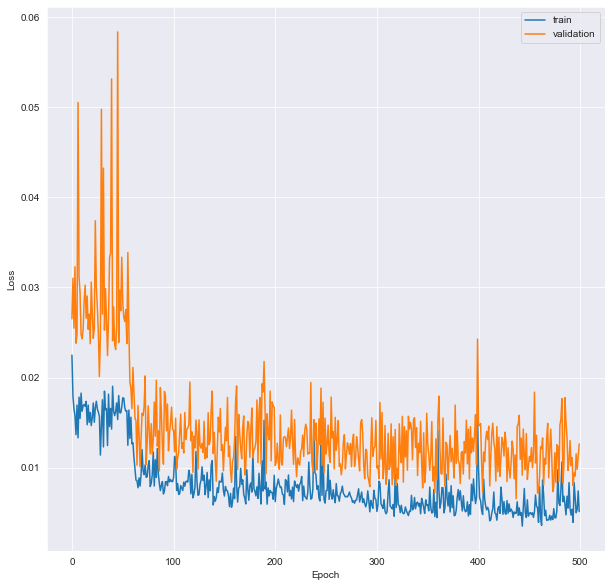

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))
line1, = axes.plot(history.epoch, history.history['loss'], label='train')
line2, = axes.plot(history.epoch, history.history['val_loss'], label='validation')
_ = axes.xaxis.set_label_text("Epoch")
_ = axes.yaxis.set_label_text("Loss")
_ = axes.legend(handles=[line1, line2])


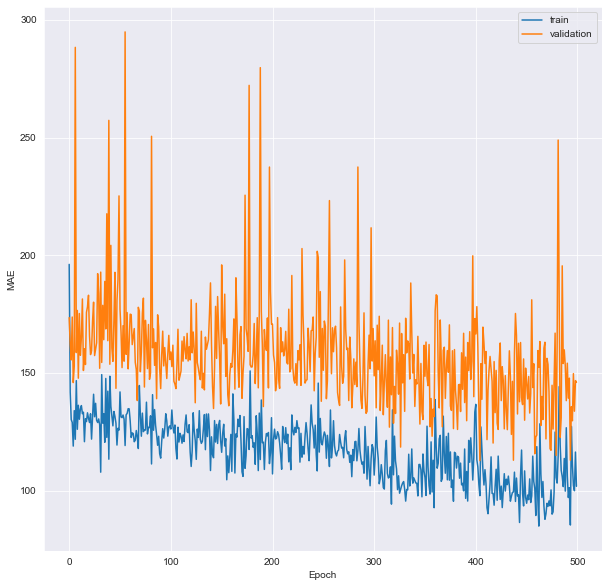

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))
line1, = axes.plot(history.epoch, history.history['mae_remaining_cycles'], label='train')
line2, = axes.plot(history.epoch, history.history['val_mae_remaining_cycles'], label='validation')
_ = axes.xaxis.set_label_text("Epoch")
_ = axes.yaxis.set_label_text("MAE")
_ = axes.legend(handles=[line1, line2])